# MLB Team RS 예측

미국 프로야구 (MLB)의 공식 Saberstat중 하나인 RS를 예측하는 모델 입니다.

컴퓨터학부 2018218007 김민수


원래주제는 AlphaPose를 이용한 야구선수 Pose Estimation 이었지만 주제를 변경하게 되었습니다.


In [1]:
#패키지 임포트
!pip install pingouin
!pip install mlxtend

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 185 kB 5.4 MB/s 
     |████████████████████████████████| 9.9 MB 54.5 MB/s 
  Created wheel for pingouin: filename=pingouin-0.5.2-py3-none-any.whl size=196208 sha256=4eca92a21f3b1f2ebf8608fd61d599bc0847ab955aea96d9e68f66edbda73c64
  Stored in directory: /root/.cache/pip/wheels/75/b0/89/f6866fc5accea9bec04f4c9f2a242520d6e8e7b8fcf89e139c
  Created wheel for littleutils: filename=littleutils-0.2.2-py3-none-any.whl size=7047 sha256=87129b286f4e54065e38eb0c196b437b9bce9295a6ba8ce6e0fd7c6f828d2d3a
  Stored in directory: /root/.cache/pip/wheels/6a/33/c4/0ef84d7f5568c2823e3d63a6e08988852fb9e4bc822034870a
Successfully built pingouin littleutils
  Attempting uninstall: statsmodels
    Found existing installation: statsmodels 0.12.2
    Uninstalling statsmodels-0.12.2:
      Successfully uninstalled statsmodels-0.12.2
Looking in indexes: https://pypi.org/simple

In [2]:
!sudo apt-get install -y fonts-nanum
!sudo fc-cache -fv
!rm ~/.cache/matplotlib -rf

Reading package lists... Done
Building dependency tree       
Reading state information... Done
The following package was automatically installed and is no longer required:
  libnvidia-common-460
Use 'sudo apt autoremove' to remove it.
The following NEW packages will be installed:
  fonts-nanum
0 upgraded, 1 newly installed, 0 to remove and 20 not upgraded.
Need to get 9,604 kB of archives.
After this operation, 29.5 MB of additional disk space will be used.
Get:1 http://archive.ubuntu.com/ubuntu bionic/universe amd64 fonts-nanum all 20170925-1 [9,604 kB]
Fetched 9,604 kB in 0s (19.6 MB/s)
debconf: unable to initialize frontend: Dialog
debconf: (No usable dialog-like program is installed, so the dialog based frontend cannot be used. at /usr/share/perl5/Debconf/FrontEnd/Dialog.pm line 76, <> line 1.)
debconf: falling back to frontend: Readline
debconf: unable to initialize frontend: Readline
debconf: (This frontend requires a controlling tty.)
debconf: falling back to frontend: Teletype

In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import seaborn as sns
import pingouin as pg
import statsmodels.api as sm
from statsmodels.formula.api import ols
import statsmodels.stats.multicomp as mc
from statsmodels.graphics.factorplots import interaction_plot
from statsmodels.stats.outliers_influence import variance_inflation_factor
from sklearn import linear_model, metrics
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.feature_selection import RFE, SelectKBest, f_regression
from sklearn.feature_selection import RFECV
from scipy import stats
from math import sqrt
import warnings
warnings.filterwarnings('ignore')
from matplotlib.axes._axes import _log as matplotlib_axes_logger
matplotlib_axes_logger.setLevel('ERROR')

pd.set_option('display.max_rows', None)
pd.set_option('display.max_columns', None)

In [4]:
plt.rc('font', family='NanumBarunGothic') 

## DATA

## 데이터셋 출처
 MLB 데이터 셋 : FanGraph.com 자체 제공 데이터셋 export 해서 사용.
  
 2000 ~ 2021 년 까지의 데이터 수집 및 사용. 22년 데이터는 있지만 아직        불완전하여 제외(EDA 단계 에서 제외하였음)

## 데이터 설명
https://drive.google.com/file/d/1hOdkjRgOHJDdXlViTXPa1kM6zrCh8CZ6/view?usp=share_link

In [5]:
data = pd.read_csv('/content/drive/MyDrive/SaberMatrix/MLB_TEAM_STAT3.csv')

Teamstat_df = data

In [6]:
Teamstat_df.head(10)

,Season,Team,G,PA,AB,R,H,AVG,OBP,SLG,OPS,ISO,1B,2B,3B,HR,BB,SO,SB,CS,wOBA,wRC+,WAR
0,2000,NYM,2345,6328,5486,807,1445,0.263,0.346,0.430,NaN,0.167,946,281,20,198,675,1037,66,46,0.339,99,23.5
1,2000,MON,2328,6153,5535,738,1475,0.266,0.326,0.432,NaN,0.165,952,310,35,178,476,1048,58,48,0.327,87,8.3
2,2000,CIN,2313,6373,5635,825,1545,0.274,0.343,0.447,NaN,0.173,1007,302,36,200,559,995,100,38,0.341,94,24.3
3,2000,HOU,2303,6444,5570,938,1547,0.278,0.361,0.477,NaN,0.199,973,289,36,249,673,1129,114,52,0.361,105,23.0
4,2000,CHC,2269,6397,5577,764,1426,0.256,0.335,0.411,NaN,0.155,948,272,23,183,632,1120,93,37,0.327,89,15.7
5,2000,COL,2221,6453,5660,968,1664,0.294,0.362,0.455,NaN,0.161,1130,320,53,161,601,907,131,61,0.353,82,15.5
6,2000,FLA,2213,6203,5509,731,1441,0.262,0.331,0.409,NaN,0.147,978,274,29,160,540,1184,168,55,0.324,89,14.5
7,2000,MIL,2207,6355,5563,740,1366,0.246,0.325,0.403,NaN,0.158,867,297,25,177,620,1245,72,44,0.319,82,11.7
8,2000,PIT,2202,6369,5643,793,1506,0.267,0.339,0.424,NaN,0.157,987,320,31,168,564,1032,86,40,0.333,91,10.6
9,2000,STL,2196,6369,5478,887,1481,0.270,0.356,0.455,NaN,0.185,962,259,25,235,675,1253,87,51,0.353,105,31.2


## EDA

In [7]:
#데이터 정제
# R = RS 로 변경(RunScored)
Teamstat_df.rename(columns = {'R': 'RS'}, inplace = True)

# 결측치 및 중복값 확인
print("각 컬럼 결측치 갯수 합:")
print(Teamstat_df.isnull().sum())
print("데이터 중복값: {}".format(Teamstat_df.duplicated().sum()))

# TB(total base), OPS 스텟 생성(NaN 값 대체)
Teamstat_df["TB"] = Teamstat_df["1B"] + (2 * Teamstat_df["2B"]) + (3 * Teamstat_df["3B"]) + (4 * Teamstat_df["HR"])
Teamstat_df["OPS"] = Teamstat_df["OBP"] + Teamstat_df["SLG"]

# MLB 리그 구분 NL/AL
nl_teams = ["ATL", "CHC", "CIN", "COL", "LAD",
            "MIL", "NYM", "PHI", "PIT", "SDP",
            "SFG", "STL", "ARI", "WSN", "FLA",
            "MIA", "MON"]
al_teams = ["MIN", "CHW", "CLE", "DET", "KCR",
            "TOR", "BAL", "BOS", "NYY", "OAK",
            "SEA", "TEX", "LAA", "TBR", "TBD",
            "ANA"]

def get_league(data):
    if data["Team"] in nl_teams:
        return "NL"
    elif data["Team"] in al_teams:
        return "AL"
    elif data["Team"] == "HOU" and data["Season"] <= 2012: # NL에서 AL 로 바뀐 팀
        return "NL"
    else:
        return "AL"

Teamstat_df["League"] = Teamstat_df.apply(lambda x: get_league(x), axis = 1)

#데이터 타입
print(Teamstat_df.dtypes)

print("Total Memory Usage Before: {}".format(Teamstat_df.memory_usage(deep = True).sum()))

# 리그, 팀 타입 변경
Teamstat_df["Team"] = Teamstat_df["Team"].astype("category")
Teamstat_df["League"] = Teamstat_df["League"].astype("category")

print("Total Memory Usage After: {}".format(Teamstat_df.memory_usage(deep = True).sum()))

#데이터 컬럼 순서 변경
cols = ["Season", "League"] + list(Teamstat_df.columns)[1:-1]
Teamstat_df = Teamstat_df.reindex(columns = cols)

각 컬럼 결측치 갯수 합:
Season      0
Team        0
G           0
PA          0
AB          0
RS          0
H           0
AVG         0
OBP         0
SLG         0
OPS       690
ISO         0
1B          0
2B          0
3B          0
HR          0
BB          0
SO          0
SB          0
CS          0
wOBA        0
wRC+        0
WAR         0
dtype: int64
데이터 중복값: 0
Season      int64
Team       object
G           int64
PA          int64
AB          int64
RS          int64
H           int64
AVG       float64
OBP       float64
SLG       float64
OPS       float64
ISO       float64
1B          int64
2B          int64
3B          int64
HR          int64
BB          int64
SO          int64
SB          int64
CS          int64
wOBA      float64
wRC+        int64
WAR       float64
TB          int64
League     object
dtype: object
Total Memory Usage Before: 209198
Total Memory Usage After: 131806


In [8]:
Teamstat_df.columns.tolist()

['Season',
 'League',
 'Team',
 'G',
 'PA',
 'AB',
 'RS',
 'H',
 'AVG',
 'OBP',
 'SLG',
 'OPS',
 'ISO',
 '1B',
 '2B',
 '3B',
 'HR',
 'BB',
 'SO',
 'SB',
 'CS',
 'wOBA',
 'wRC+',
 'WAR',
 'TB']

In [9]:
Teamstat_df.head(10)

,Season,League,Team,G,PA,AB,RS,H,AVG,OBP,SLG,OPS,ISO,1B,2B,3B,HR,BB,SO,SB,CS,wOBA,wRC+,WAR,TB
0,2000,NL,NYM,2345,6328,5486,807,1445,0.263,0.346,0.430,0.776,0.167,946,281,20,198,675,1037,66,46,0.339,99,23.5,2360
1,2000,NL,MON,2328,6153,5535,738,1475,0.266,0.326,0.432,0.758,0.165,952,310,35,178,476,1048,58,48,0.327,87,8.3,2389
2,2000,NL,CIN,2313,6373,5635,825,1545,0.274,0.343,0.447,0.790,0.173,1007,302,36,200,559,995,100,38,0.341,94,24.3,2519
3,2000,NL,HOU,2303,6444,5570,938,1547,0.278,0.361,0.477,0.838,0.199,973,289,36,249,673,1129,114,52,0.361,105,23.0,2655
4,2000,NL,CHC,2269,6397,5577,764,1426,0.256,0.335,0.411,0.746,0.155,948,272,23,183,632,1120,93,37,0.327,89,15.7,2293
5,2000,NL,COL,2221,6453,5660,968,1664,0.294,0.362,0.455,0.817,0.161,1130,320,53,161,601,907,131,61,0.353,82,15.5,2573
6,2000,NL,FLA,2213,6203,5509,731,1441,0.262,0.331,0.409,0.740,0.147,978,274,29,160,540,1184,168,55,0.324,89,14.5,2253
7,2000,NL,MIL,2207,6355,5563,740,1366,0.246,0.325,0.403,0.728,0.158,867,297,25,177,620,1245,72,44,0.319,82,11.7,2244
8,2000,NL,PIT,2202,6369,5643,793,1506,0.267,0.339,0.424,0.763,0.157,987,320,31,168,564,1032,86,40,0.333,91,10.6,2392
9,2000,NL,STL,2196,6369,5478,887,1481,0.270,0.356,0.455,0.811,0.185,962,259,25,235,675,1253,87,51,0.353,105,31.2,2495


리그 평균 팀득점 연도별 변화

bar plot 과 box plot을 이용해 시각화

------- 연도별 리그 RS 평균값 변화 -------
    Season     RS
0     2000  832.4
1     2001  773.3
2     2002  746.9
3     2003  765.9
4     2004  779.2
5     2005  744.2
6     2006  786.6
7     2007  777.4
8     2008  752.8
9     2009  747.3
10    2010  710.3
11    2011  693.6
12    2012  700.6
13    2013  675.2
14    2014  658.7
15    2015  688.2
16    2016  724.8
17    2017  752.7
18    2018  721.0
19    2019  782.2
20    2020  278.1
21    2021  733.7
22    2022  693.9


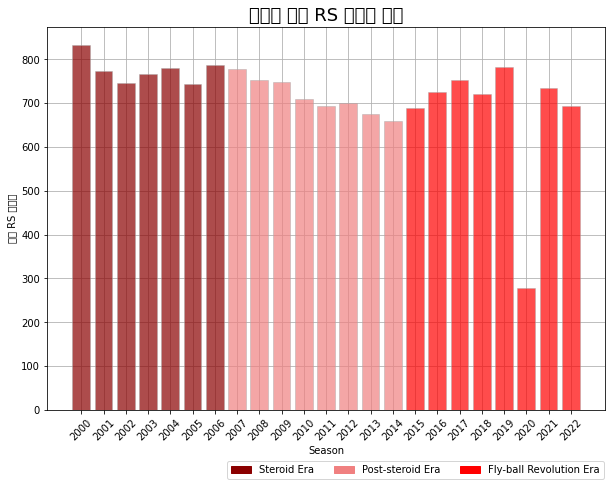

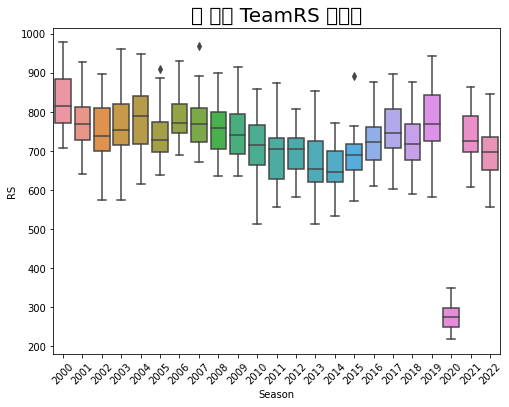

In [10]:
season_df = Teamstat_df.groupby("Season")
lg_avg_rs = season_df["RS"].mean().round(1).reset_index()
print("------- 연도별 리그 RS 평균값 변화 -------")
print(lg_avg_rs)

# bar plot
values = np.array(lg_avg_rs["RS"])
idx = np.array(lg_avg_rs["Season"])
c1 = mpatches.Patch(color = "darkred", label = "Steroid Era")
c2 = mpatches.Patch(color = "lightcoral", label = "Post-steroid Era")
c3 = mpatches.Patch(color = "red", label = "Fly-ball Revolution Era")

fig, ax = plt.subplots(figsize = (10, 7))

plt.bar(idx, values, edgecolor = "darkgrey", linewidth = 0.6,
        color = ["darkred"] * 7 + ["lightcoral"] * 8 + ["red"] * 8,
        alpha = 0.7, zorder = 3)
plt.xticks(lg_avg_rs["Season"], rotation = 45)
plt.xlabel("Season")
plt.ylabel("리그 RS 평균값")
plt.title("연도별 리그 RS 평균값 변화", fontsize = 18)
plt.legend(handles = [c1, c2, c3], ncol = 3,
           bbox_to_anchor= (0.66, -0.12), loc = "upper center")
plt.grid(zorder = 0)
fig.subplots_adjust(bottom = 0.12)
plt.show()

# box plot
fig, ax = plt.subplots(figsize = (8, 6))

sns.boxplot(x = "Season", y = "RS", data = Teamstat_df, ax = ax)
ax.set_xticklabels(ax.get_xticklabels(), rotation = 45)
ax.set_title("각 시즌 TeamRS 분포도", fontsize = 20)
plt.show()

위 시각화 자료를 통해 2000년 이후 연도별 리그 RS 평균값을 알수 있다. 2006년 까지는 높은 RS를 보여주지만 06 ~ 14까지는 하향세 그리고 15년 이후로 다시 상승세를보인다 하지만 근 3년간은 감소세를 다시 보이고 있다.

2020시즌은 코로나 19로 인해 경기수를 60경기로 축소해서 기존의 162경기와 차이가 커서 RS값이 비정상적이다.

연도별 RS값은 차이가 있는데 이 차이가 유의미한 차이인지는 아래와 같다.

시대를 분할해준다. MLB의 RS는 규칙 및 경기수. 약물등 외부요인에대해 상당한 영향을 받는다.
규칙과 경기는 근 20년간 크게 바뀐것이 없으므로 약물에 관련해 시대를 구분했다.

00년대 중반 까지만해도 PED라는 스테로이드성 약물사용에대한 검사와 처벌이 까다롭지 않았다. (steroid Era)

06년 이후로부터 PED 등 스테로이드성 약물에 대한 검사 및 처벌이 엄격해졌다. (Post-steroid Era)

14-15년 이후로 스탯캐스트(2차 세이버매트릭스 혁명) 으로 인해 Fly-ball 혁명이 일어났다.(타구 발사각도를 높여 공을 되도록 멀리 높게 날려보내는 전술). 실제로 MLB 각팀에서도 기존의 방식에서 벗어나 장타를 치는 선수로만 타선을 채우는 등의 변화가 일어났다. (Flyball Revolution Era)

그래서 시대를 크게 3개로 나누고 분위수 대조도로 시각화 했다.


In [11]:
# 시대 구분
def get_era(data):
    if data["Season"] <= 2006:
        return "Steroid Era"
    elif data["Season"] > 2006 and data["Season"] <= 2014:
        return "Post-steroid Era"
    else:
        return "Fly-ball Revolution Era"

Teamstat_df["Era"] = Teamstat_df.apply(lambda x: get_era(x), axis = 1)
Teamstat_df["Era"] = Teamstat_df["Era"].astype("category")

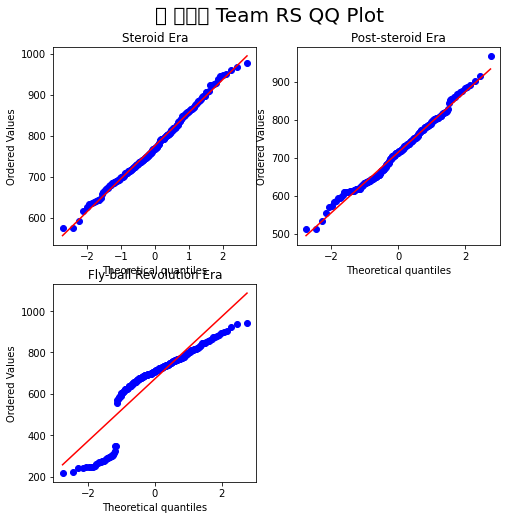

In [12]:
# 분석 및 분위수 대조도 시각화
eras = Teamstat_df["Era"].unique()
fig = plt.figure(figsize = (8, 8))

for era, i in zip(eras, range(1, 5)):
    ax = fig.add_subplot(2, 2, i)
    stats.probplot(Teamstat_df.loc[Teamstat_df["Era"] == era]["RS"], plot = plt)
    ax.set_title("{}".format(era))
    ax.set
fig.suptitle("각 시대상 Team RS QQ Plot", fontsize = 20, y = 0.95)
plt.show()

뜬공혁명 시대상의 그래프가 좋지 않다. 아마도 2020년도 코로나 19로인한 단축시즌 데이터가 포함되어 그런것 같아 아래에서 제거했다.

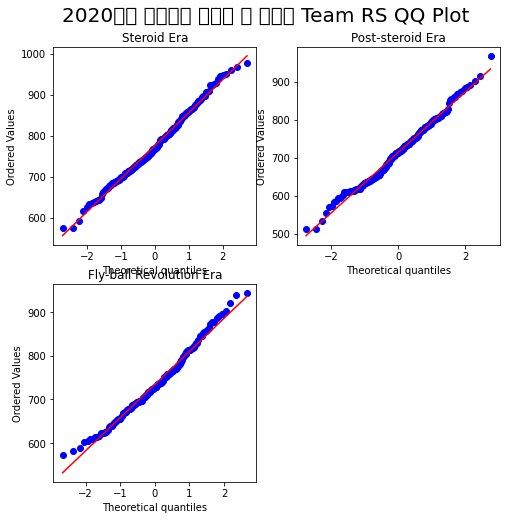

------- Team Runs Scored Descriptive Statistics by Era -------
                         count        mean        std    min     25%    50%     75%    max
Era                                                                                       
Fly-ball Revolution Era  180.0  733.777778  75.455974  573.0  682.75  729.0  777.25  943.0
Post-steroid Era         240.0  714.479167  79.132956  513.0  650.00  714.5  770.00  968.0
Steroid Era              210.0  775.509524  80.319651  574.0  718.25  768.5  826.75  978.0


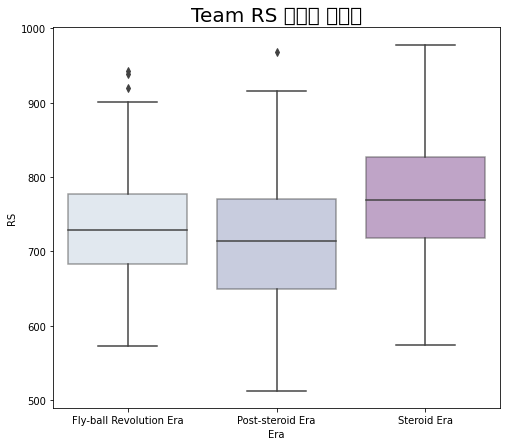

In [13]:
# 2020년도 데이터 제거 (정규 경기수 미달)
# 2022년도 데이터 제거 (완전한 기록 x)
Teamstat_df = Teamstat_df.loc[Teamstat_df["Season"] != 2020]
Teamstat_df = Teamstat_df.loc[Teamstat_df["Season"] != 2022]
# 데이터 제거후 다시 분석 및 시각화(일원 분산 분석)
eras = Teamstat_df["Era"].unique()
fig = plt.figure(figsize = (8, 8))

for era, i in zip(eras, range(1, 5)):
    ax = fig.add_subplot(2, 2, i)
    stats.probplot(Teamstat_df.loc[Teamstat_df["Era"] == era]["RS"], plot = plt)
    ax.set_title("{}".format(era))
fig.suptitle("2020년도 데이터를 제거한 각 시대상 Team RS QQ Plot ", fontsize = 20, y = 0.95)
plt.show()

era_df = Teamstat_df.groupby("Era")
rs_sum_era = era_df["RS"].describe()
print("------- Team Runs Scored Descriptive Statistics by Era -------")
print(rs_sum_era.to_string())

# box plot
fig, ax = plt.subplots(figsize = (8, 7))

sns.boxplot(x = "Era", y = "RS", data = Teamstat_df, ax = ax,
            palette = "BuPu", boxprops = dict(alpha = 0.5))
ax.set_xticklabels(ax.get_xticklabels())
ax.set_title("Team RS 시대상 분포도", fontsize = 20)
plt.show()

2020년 데이터를 제거했더니 선형이 좋아졌다.

이후로 부턴 2020년 데이터를 제거한 데이터를 사용한다.

In [14]:
# 일원 배치 분산분석 F-검정
model = ols("RS ~ C(Era)", data = Teamstat_df).fit()
one_aov_table = sm.stats.anova_lm(model, typ = 1)
one_aov_table.round(3)
# F-검정 식 : H0:μ1=μ2=μ3   vs   H1: at least one μi≠μj 

,df,sum_sq,mean_sq,F,PR(>F)
C(Era),2.0,428007.172,214003.586,34.725,0.0
Residual,627.0,3864089.488,6162.822,NaN,NaN


In [15]:
# Bonferroni보정을 적용한 일원 배치 분산분석 및 검정
compar = mc.MultiComparison(Teamstat_df['RS'], Teamstat_df['Era'])
table, a1, a2 = compar.allpairtest(stats.ttest_ind, method = "bonf")
table

group1,group2,stat,pval,pval_corr,reject
Fly-ball Revolution Era,Post-steroid Era,2.5229,0.012,0.036,True
Fly-ball Revolution Era,Steroid Era,-5.2596,0.0,0.0,True
Post-steroid Era,Steroid Era,-8.1051,0.0,0.0,True


 Bonferroni 보정을 이용한 분석 결과에 Pval_corr 값이 0.05 보다 작다는 것은 모든 그룹 평균 차이가 5%의 유의수준에서 통계적으로 유의미 하다는 것을 보여준다.

AL/NL 은 각각 타자 라인업 규정이 다르기에 통상적으로 AL 팀이 득점기회가 더 크다고 알려져 있다. 이제 리그에서의 차이를 알아본다.

In [16]:
# NL, AL 어디가 더 많은 득점을 얻었는지 분석한다.
# 리그단위로 데이터를 묶고 진행했다.
lg_df = Teamstat_df.groupby("League")
leagues = Teamstat_df["League"].unique()
print("------- Team Runs Scored Descriptive Statistics by League -------")
print(lg_df["RS"].describe())

nl_rs = Teamstat_df.loc[Teamstat_df["League"] == "NL"]["RS"]
al_rs = Teamstat_df.loc[Teamstat_df["League"] == "AL"]["RS"]

------- Team Runs Scored Descriptive Statistics by League -------
        count        mean        std    min     25%    50%     75%    max
League                                                                   
AL      302.0  759.360927  85.364601  513.0  700.25  751.0  816.75  978.0
NL      328.0  722.820122  75.999646  513.0  667.75  723.5  773.25  968.0


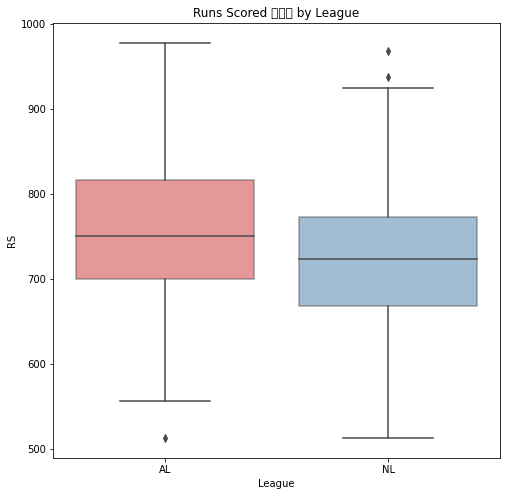

In [17]:
# box plot
fig, ax = plt.subplots(figsize = (8, 8))
sns.boxplot(x = "League", y = "RS", data = Teamstat_df, palette = "Set1", boxprops = dict(alpha = 0.5))
ax.set(title = "Runs Scored 분포도 by League")
plt.show()

위 수치 및 시각화 자료로 근 20년간 평균적으로 AL팀에 비해 NL팀이 상대적으로 적은 득점(RS)를 기록 했다는 것을 알 수 있다.
이 차이가 유의한지 알기위해 독립표본 t 검정을 사용한다.

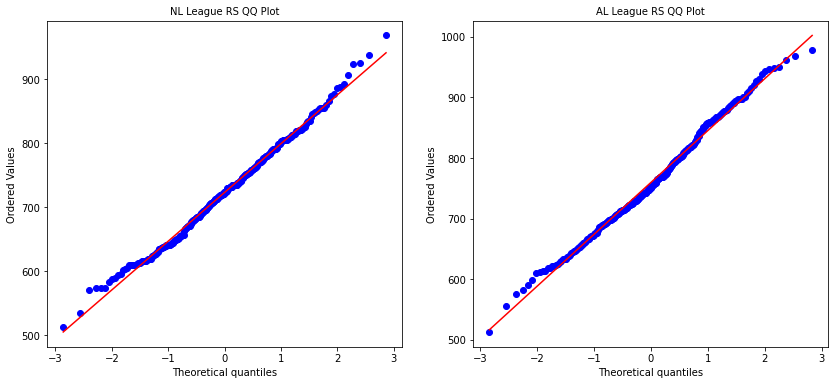

In [18]:
# 두 집단간 비교
nl_rs = Teamstat_df.loc[Teamstat_df["League"] == "NL"]["RS"]
al_rs = Teamstat_df.loc[Teamstat_df["League"] == "AL"]["RS"]

fig, axes = plt.subplots(1, 2, figsize = (14, 6))
stats.probplot(nl_rs, plot = axes[0])
stats.probplot(al_rs, plot = axes[1])
axes[0].set_title("NL League RS QQ Plot", fontsize = 10)
axes[1].set_title("AL League RS QQ Plot", fontsize = 10)
plt.show()

In [19]:
# 두집단간 T-검정
test_result = pg.ttest(al_rs, nl_rs, paired = False, alternative = 'greater', correction = False).round(3)
test_result

,T,dof,alternative,p-val,CI95%,cohen-d,BF10,power
T-test,5.683,628,greater,0.0,"[25.95, inf]",0.453,9.036e+05,1.0


t- 검정 결과에 따라 P-val 값은 0이므로 AL팀이 평균 5% 유의 수준에서 NL팀에 비해 더 많은 득점을 가진다라고 말할수 있다.

Era 와 리그 사이에 상호관계가 있는지 알아보기위해 f1에 Era, f2에 리그 반응변수에 RS를 두고 이원 분산 분석 수행.

In [20]:
# f1: "Era", f2: "League"
model = ols("RS ~ C(Era) + C(League) + C(Era):C(League)", data = Teamstat_df).fit()
two_aov_table = sm.stats.anova_lm(model, typ = 2)
print("------- 이원분산분석 -------")
two_aov_table.round(3)

------- 이원분산분석 -------


,sum_sq,df,F,PR(>F)
C(Era),434873.929,2.0,37.325,0.000
C(League),216807.370,1.0,37.217,0.000
C(Era):C(League),12134.950,2.0,1.042,0.354
Residual,3635147.168,624.0,NaN,NaN


위 결과에따라 Era(시대)에 따라  각 팀 RS 에 영향을 준다고 할수있다.
리그 역시 각 팀의 RS에 영향을 준다고 할수 있다.
하지만 각 리그에 대해 시대상이 다르게 적용되었다고 볼수는 없다.


이원 분산 분석

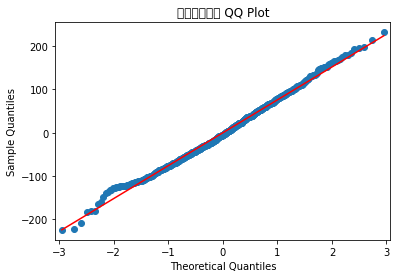

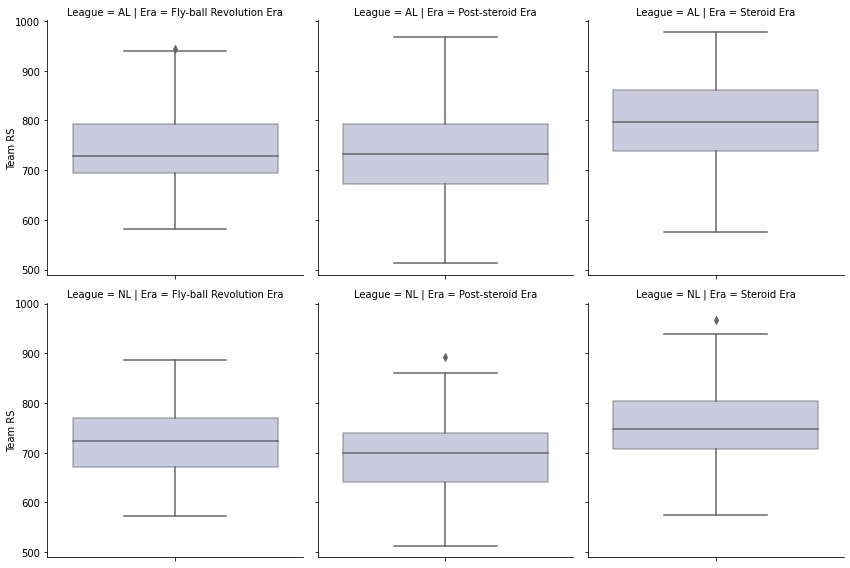

In [21]:
fig = sm.qqplot(model.resid, line = "s")
plt.title("이원분산분석 QQ Plot")
plt.show()

# equal-variance
g = sns.FacetGrid(Teamstat_df, col = "Era", row = "League", height = 4, aspect = 1)
g.map_dataframe(sns.boxplot, y = "RS", data = Teamstat_df,
                palette = "BuPu", boxprops = dict(alpha = 0.5))
g.set_axis_labels(y_var = "Team RS", labelpad = -2)
plt.show()

잔차가 진단 선에 가까우며 상자그림의 IQR은 대략적으로 동일하다. 또한 관측치는 서로 독립적이므로 정규성, 등분산, 독립성을 만족한다.

## Feature Select

MLR 모델을 사용한 RS 예측 을 위해 모든 독립 변수와 RS 사이간의 상관관계 시각화

Initial total number of numerical independent variables: 22


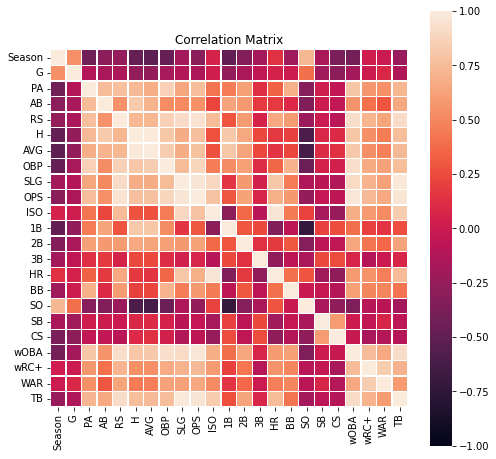

In [22]:
Teamstat_df["League"] = Teamstat_df["League"].astype("category")
init_var_num = len(Teamstat_df.select_dtypes(exclude = "category").columns)
print("Initial total number of numerical independent variables: {}".format(init_var_num - 1))

# correlation matrix
corrMatrix = Teamstat_df.corr()
fig, ax = plt.subplots(figsize = (8, 8))

sns.heatmap(corrMatrix, square = True, linewidths = 0.3, vmax = 1, vmin = -1)
plt.title('Correlation Matrix')
plt.show()

In [23]:
# RS와 상관관계 지표가 0.65 이하인 변수 제거
corrMatrix = abs(Teamstat_df.corr())
cols = list(corrMatrix.columns)
vars_to_drop = []
for col in cols:
    if corrMatrix[col]['RS'] < 0.65:
        vars_to_drop.append(col)

filtered_df = Teamstat_df.loc[:, ~Teamstat_df.columns.isin(vars_to_drop)]
filtered_vars = list(filtered_df.select_dtypes(exclude = "category").columns)
print(filtered_vars)

['PA', 'RS', 'H', 'AVG', 'OBP', 'SLG', 'OPS', 'ISO', 'HR', 'wOBA', 'wRC+', 'TB']


RS와 상관관계가 0.65 미만인 독립변수 필터링.
필터링후 위 12개 스텟 사용.

위 12개 스텟간 쌍별 상관 관계 파악후 높은 독립변수 제외.

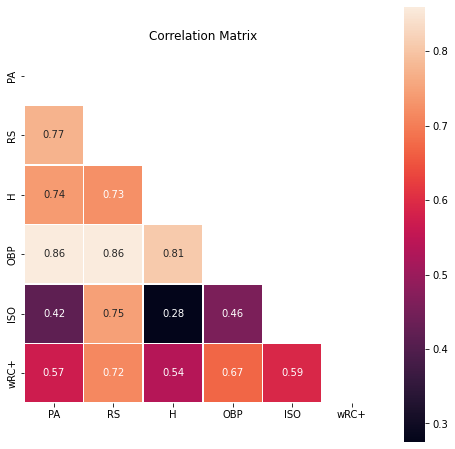

In [24]:
# 다른 독립변수와 pairwise correlation이 0.9 이상으로 나온 독립변수를 제거
ind_vars_df = filtered_df.iloc[:, filtered_df.columns != 'RS']

corrMatrix = abs(filtered_df.corr())
upperTri = corrMatrix.where(np.triu(np.ones(corrMatrix.shape), k = 1).astype(np.bool))
vars_to_drop = [col for col in upperTri.columns if any(upperTri[col] >= 0.9)]
filtered_df.drop(vars_to_drop, axis = 1, inplace = True)

# 상관관계 매트릭스 생성
new_corr = filtered_df.corr()
fig, ax = plt.subplots(figsize = (8, 8))

mask = np.triu(np.ones_like(new_corr))
sns.heatmap(new_corr, mask = mask, square = True, linewidths = 0.5, annot = True, annot_kws = {'size': 10},
            xticklabels = new_corr.columns, yticklabels = new_corr.columns)
plt.title('Correlation Matrix')

plt.show()

PA, RS, H, OBP, ISO, wRC+ 의 5개의 스텟이 남았으며 MLR 모델 에 대해 최적의 예측 변수를 찾기위해 RFE(재귀 기능 제거)를 사용한다.

In [25]:
# select numerical data
num_df = filtered_df.select_dtypes(exclude = "category")
x = num_df.loc[:, num_df.columns != 'RS']
y = num_df['RS']
cols = list(x.columns)

model = LinearRegression()

#selector = RFECV(estimator = model, step=1, cv = 5)
selector = RFE(estimator = model, n_features_to_select = 2, step =1) #verbose = 2)
x_rfe = selector.fit_transform(x, y)
model.fit(x_rfe, y)

temp = pd.Series(selector.support_, index = cols)
selected_vars = list(temp[temp == True].index)
print('RFE Features: {}'.format(selected_vars))

RFE Features: ['OBP', 'ISO']


RFE 가 추천한 Feature는 OBP 와 ISO 이다.

VIF 점수 확인

In [26]:
# VIF
x = num_df[selected_vars]
x = sm.add_constant(x)
y = num_df['RS']

lm = sm.OLS(y, x)
result_rs = lm.fit()
print(result_rs.summary())

vif = pd.DataFrame()
vif['Feature'] = lm.exog_names
vif['VIF'] = [variance_inflation_factor(lm.exog, i) for i in range(lm.exog.shape[1])]
print(vif[vif['Feature'] != 'const'])

                            OLS Regression Results                            
Dep. Variable:                     RS   R-squared:                       0.896
Model:                            OLS   Adj. R-squared:                  0.895
Method:                 Least Squares   F-statistic:                     2696.
Date:                Fri, 16 Dec 2022   Prob (F-statistic):          1.16e-308
Time:                        11:09:47   Log-Likelihood:                -2961.9
No. Observations:                 630   AIC:                             5930.
Df Residuals:                     627   BIC:                             5943.
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const       -772.5955     24.460    -31.587      0.0

각 Feature VIF 점수는 1.269 점으로 다중 공선성이 낮다. 이제 이 2개의 예측 변수를 가지고 데이터를 train , test 셋으로 분할해 MLR 모델을 구축한다.

## Multiple Linear Regression

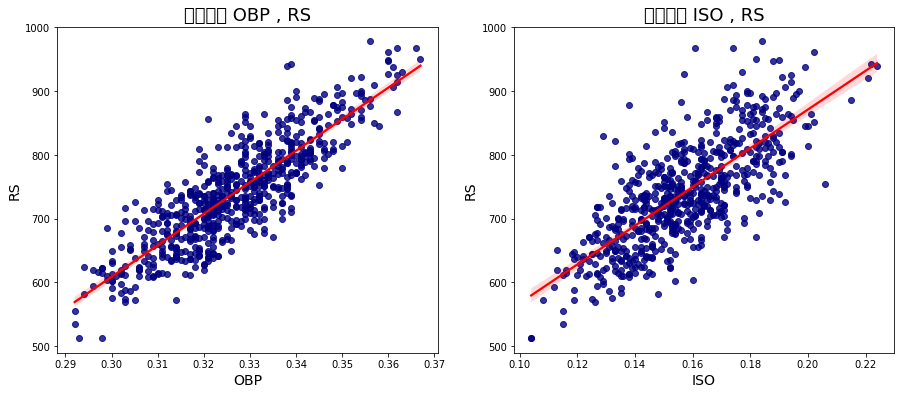

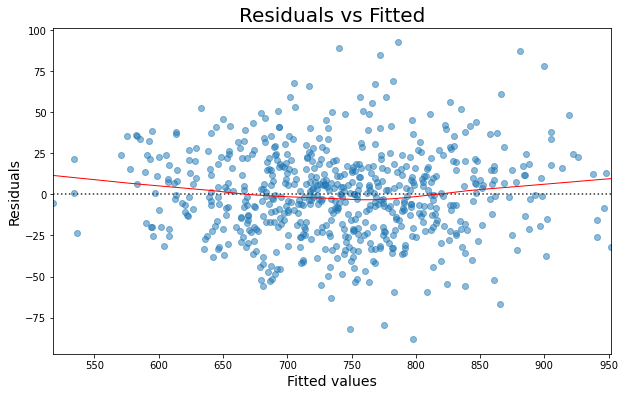

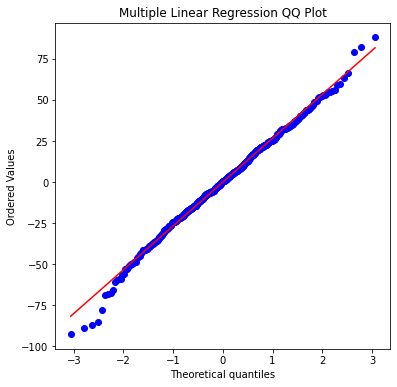

In [27]:
# 피쳐로 RS, OBP, ISO 선택
mlr_df = Teamstat_df.loc[:, ["RS", "OBP", "ISO"]]

# linearity
# scatter plots
cols = list(mlr_df.drop('RS', axis = 1).columns)

fig, axes = plt.subplots(1, 2, figsize = (15, 6))

for col, ax in zip(cols, axes.flatten()[:2]):
    sns.regplot(x = col, y = 'RS', data = mlr_df, scatter_kws = {'color': 'navy'},
                line_kws = {'color': 'red'}, ax = ax)
    ax.set_title('상관관계 {} , RS'.format(col), fontsize = 18)
    ax.set_xlabel(col, fontsize = 14)
    ax.set_ylabel('RS', fontsize = 14)

plt.show()

# homoscedasticity
# residual plot
model = linear_model.LinearRegression().fit(x, y)
fitted_y = model.predict(x)
resid = fitted_y - y

fig = plt.subplots(figsize = (10, 6))
sns.residplot(fitted_y, "RS", data = mlr_df, lowess = True,
              scatter_kws = {"alpha": 0.5}, line_kws = {"color": "red", "lw": 1})
plt.xlabel("Fitted values", fontsize = 14)
plt.ylabel("Residuals", fontsize = 14)
plt.title("Residuals vs Fitted", fontsize = 20)
plt.show()

# normality
# QQ plot
fig = plt.subplots(figsize = (6, 6))
stats.probplot(resid, dist = "norm", plot = plt)
plt.title("Multiple Linear Regression QQ Plot")
plt.show()

In [28]:
# Multiple Linear Regression with feature selection
# 훈련, 테스트 데이터셋 분리 및 모델 빌드
# multiple linear regression (x:'OBP', 'ISO' / y:'RS')
x = mlr_df[selected_vars]
y = mlr_df['RS']

x_train, x_test, y_train, y_test = train_test_split(x, y, test_size = 0.2, random_state = 1)

mlr = linear_model.LinearRegression().fit(x_train, y_train)
y_predicted = mlr.predict(x_test)

# multiple linear regression results
print('------- Multiple Linear Regression -------')
print("Intercept: {}".format(mlr.intercept_))
print("Coefficients: {}".format(mlr.coef_))

print("R-squared: {}".format(metrics.r2_score(y_test, y_predicted)))
mse = metrics.mean_squared_error(y_test, y_predicted)
print("RMSE: {}".format(sqrt(mse)))
print("MAE: {}".format(metrics.mean_absolute_error(y_test, y_predicted)))

------- Multiple Linear Regression -------
Intercept: -772.8476986765462
Coefficients: [3762.70352411 1809.81659378]
R-squared: 0.8899374241514036
RMSE: 28.54962471518895
MAE: 23.53190264577345


## 모델 결과

모델 평가
R-squared 값은 0.89

RMSE 값은 28.5

MAE 값은 23.5

MAE 값을 한시즌 경기수인 162경기로 나누면 경기당 절대 오차의 평균은 약 0.14점이다.